In [7]:
# Load the 2015 sales data and create a small feature list
import numpy as np
import geopandas as gpd

stp_sales_2015 = gpd.read_file('./data/stpete_sales_2015.shp')
stp_sales_2015["x"] = stp_sales_2015.centroid.map(lambda p: p.x)
stp_sales_2015["y"] = stp_sales_2015.centroid.map(lambda p: p.y)
stp_sales_2015_x = stp_sales_2015[['AVE_FAM_SZ', 'AVE_HH_SZ', 'MED_AGE', 'x', 'y', 'lisa']]
stp_sales_2015_x

,AVE_FAM_SZ,AVE_HH_SZ,MED_AGE,x,y
0,2.777506,2.19,46,-82.642882,27.810570
1,2.777506,2.19,46,-82.646179,27.811467
2,2.777506,2.19,46,-82.644930,27.812377
3,2.777506,2.19,46,-82.643034,27.813685
4,2.777506,2.19,46,-82.644526,27.813679
5,2.777506,2.19,46,-82.644526,27.813679
6,3.409266,2.03,40,-82.636362,27.814621
7,3.409266,2.03,40,-82.635840,27.814619
8,3.409266,2.03,40,-82.635399,27.815135
9,2.027027,1.59,39,-82.636061,27.816035


In [8]:
# Create an 80/20 training test split
from sklearn.cross_validation import train_test_split
FIGSIZE = (11, 7)
# # split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(stp_sales_2015_x,
                                                    stp_cenacs['price'],
                                                    test_size=0.2,
                                                    random_state=1)
names = stp_cenacs_x.columns.values
X_train

/home/tankofvines/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,AVE_FAM_SZ,AVE_HH_SZ,MED_AGE,x,y
975,3.321267,2.68,45,-82.722219,27.802207
799,3.368039,2.68,44,-82.631658,27.734915
1851,3.966667,3.19,39,-82.694802,27.779365
1114,3.709302,2.26,43,-82.752388,27.800284
3090,3.607981,2.46,36,-82.673372,27.711176
3067,2.652913,1.91,58,-82.683745,27.725009
3645,3.368030,2.47,43,-82.607794,27.810258
2456,3.798913,3.28,37,-82.681386,27.767093
305,2.437086,1.47,41,-82.642526,27.784171
1468,3.804348,2.39,34,-82.658787,27.794137


In [10]:
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['MEDHHINC'] = y_train
_ = X_df.hist(column=['AVE_FAM_SZ', 'AVE_HH_SZ', 'MED_AGE', 'x', 'y'], figsize=FIGSIZE)

In [12]:
# Create a GBM regressor and compare to other models
import time
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

res = defaultdict(dict)

def benchmark(est, name=None):
    if not name:
        name = est.__class__.__name__
    t0 = time.clock()
    est.fit(X_train, y_train)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = est.predict(X_test)
    res[name]['test_time'] = time.clock() - t0
    res[name]['MAE'] = mean_absolute_error(y_test, pred)
    return est
    
benchmark(DummyRegressor())
benchmark(Ridge(alpha=0.0001, normalize=True))
benchmark(Pipeline([('std', StandardScaler()), 
                    ('svr', SVR(kernel='rbf', C=10.0, gamma=0.1, tol=0.001))]), name='SVR')
benchmark(RandomForestRegressor(n_estimators=100, max_features=5, random_state=0, 
                                bootstrap=False, n_jobs=4))
est = benchmark(GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.1,
                                          loss='huber', min_samples_leaf=3, 
                                          random_state=0))

res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'MAE']].sort('MAE', ascending=False)

/home/tankofvines/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,train_time,test_time,MAE
DummyRegressor,0.001320,0.000272,126885.014194
SVR,0.695903,0.064724,111822.274257
Ridge,0.008977,0.000288,111210.979456
RandomForestRegressor,1.814874,0.041150,85022.363945
GradientBoostingRegressor,1.164642,0.005644,67292.462187


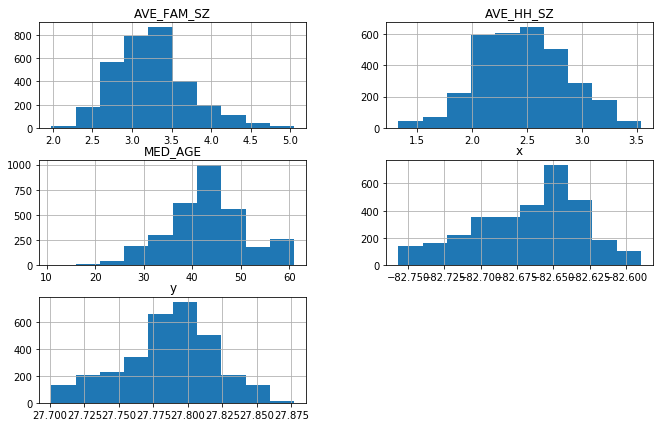

In [14]:
# plot histograms of target and features
% matplotlib inline
import pandas as pd
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['price'] = y_train
_ = X_df.hist(column=['AVE_FAM_SZ', 'AVE_HH_SZ', 'MED_AGE', 'x', 'y'], figsize=FIGSIZE)

/home/tankofvines/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


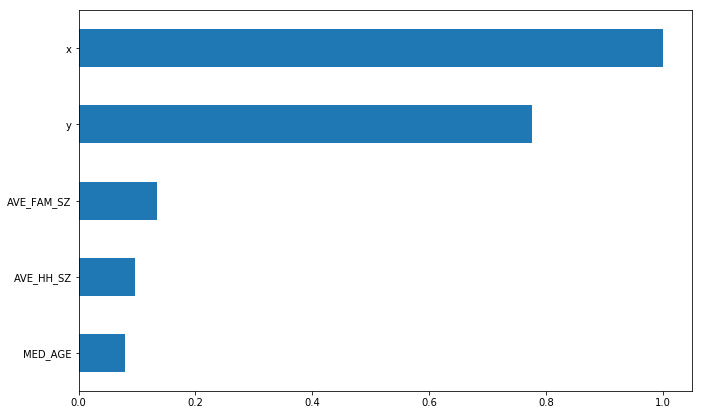

In [15]:
# Plot feature impact
fx_imp = pd.Series(est.feature_importances_, index=names)
fx_imp /= fx_imp.max()  # normalize
fx_imp.sort()
fx_imp.plot(kind='barh', figsize=FIGSIZE)

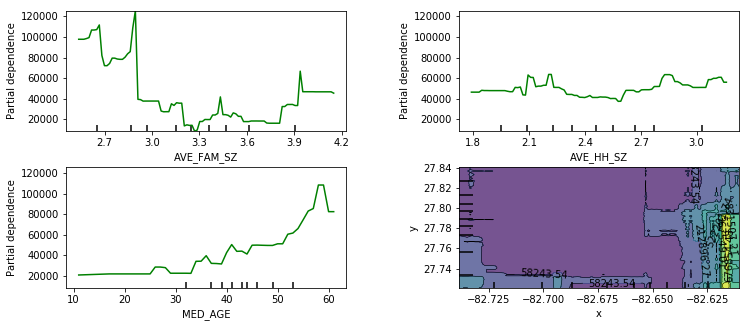

In [16]:
# 1 way and 2 way partial dependence for features
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['AVE_FAM_SZ', 'AVE_HH_SZ', 'MED_AGE',
            ('x', 'y')]
fig, axs = plot_partial_dependence(est, X_train, features, feature_names=names, 
                                   n_cols=2, figsize=FIGSIZE)